# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\CCS\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\CCS\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

('Number of data points in our data', (5000, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3032.85it/s]


In [23]:
preprocessed_reviews[1500]

u'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# Collecting 100k rows without repetition from time_sorted_data dataframe
my_final = data.take(np.random.permutation(len(final))[:100000])

In [25]:
from sklearn.model_selection import train_test_split
x = my_final['Text'].values
y = my_final['Score']

In [26]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

### [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW, SET 1

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(my_final)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

#final_counts = count_vect.transform(my_final)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])


X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)

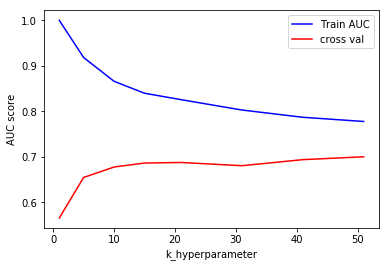

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
#neighbors = list(range(20, 80, 4))
neighbors = [1,5,10,15,21,31,41,51]
#neighbors = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    #model = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()





In [29]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 15)


In [30]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

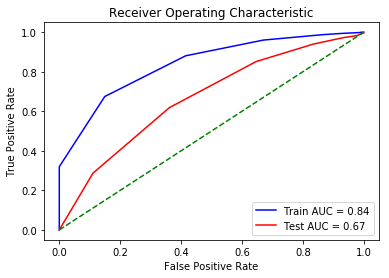

In [31]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[   5  390]
 [   3 2045]]
Test confusion matrix
[[   0  235]
 [   5 1256]]


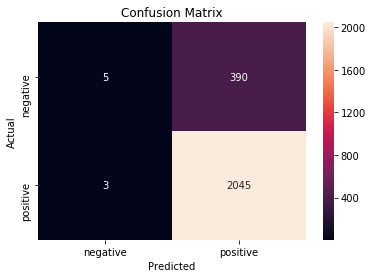

In [34]:
import seaborn as sb

conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [35]:
from sklearn.metrics import classification_report
prediction = model.predict(X_test)
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       235
           1       0.84      1.00      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.42      0.50      0.46      1496
weighted avg       0.71      0.84      0.77      1496



### [5.1.2] Applying KNN brute force on TFIDF, SET 2


In [36]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [37]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)


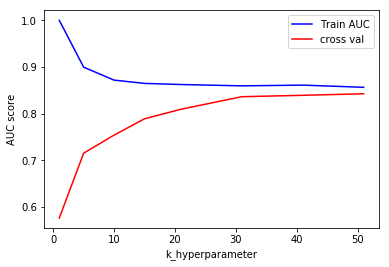

In [38]:
neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()





In [39]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 15)


In [40]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

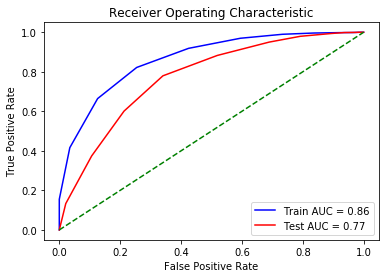

In [41]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[  66  339]
 [   8 2030]]
Test confusion matrix
[[  25  210]
 [   8 1253]]


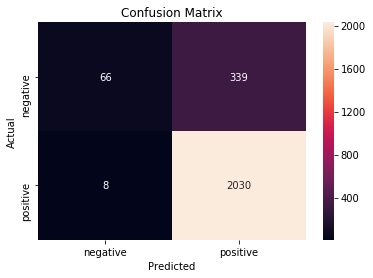

In [43]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

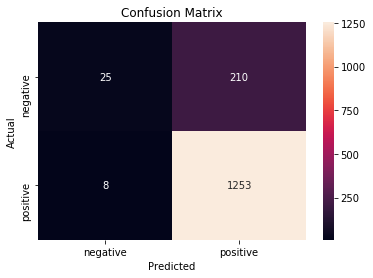

In [44]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [45]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.76      0.11      0.19       235
           1       0.86      0.99      0.92      1261

   micro avg       0.85      0.85      0.85      1496
   macro avg       0.81      0.55      0.55      1496
weighted avg       0.84      0.85      0.80      1496



### [5.1.3] Applying KNN brute force on AVG W2V, SET 3

In [46]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [47]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [48]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

('number of words that occured minimum 5 times ', 3278)
('sample words ', [u'limited', u'ever.', u'better!', u'better,', u'saves', u'Sugar', u'four', u'sleep', u'oldest', u'saved', u'Until', u'forget', u'up.', u'increase', u'up,', u'feeding', u'(for', u'contained', u'up!', u'Nirvana', u'list', u'candy.', u'under', u'sorry', u'worth', u'better.', u'Steaz', u'powder.', u'GF', u'powder,', u'container.', u'every', u'this.<br', u'today.', u'pepper.', u"daughter's", u"we'll", u'baking', u'problems.', u'companies', u'stars.', u'convenience', u'Go', u'commented', u'enjoy', u'chew', u'me!', u'her.', u'tired', u'sodium,'])


### Converting Reviews into Numerical Vectors using W2V vectors


### Algorithm: Avg W2V

In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 2443/2443 [00:08<00:00, 287.38it/s]


(2443L, 50L)
[ 0.40379352  0.58038465 -0.2688454  -0.0308261  -0.46381515 -0.08043149
  0.02172283 -0.12351171  0.13923943  0.19608952  0.08681416 -0.57795341
 -0.63877143 -0.20317637  0.06559087  0.59993864 -0.09583122 -0.4182447
  0.23660991 -0.53978164 -0.64882526 -0.03425099  0.49838594  0.5276171
  0.60222435  0.17103043 -0.17001947  0.24744023 -0.69255624 -0.56683309
 -1.01117969  0.72200769 -0.25106503 -0.20349501  0.00625263  0.61158132
 -0.06896289  0.25108394  0.12702637 -0.84012513 -0.53637155  0.10699663
 -0.42303948  0.23530784 -0.18276312  0.00461514  0.21650309  0.21245899
  0.54946882  0.25991804]


In [51]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 1047/1047 [00:03<00:00, 277.42it/s]


(1047L, 50L)
[ 0.45963886  0.59829525 -0.2437248   0.0011466  -0.52302608 -0.13562326
  0.00771283 -0.18404057  0.14704335  0.24301068  0.07510333 -0.55113572
 -0.67683889 -0.19663473  0.06868956  0.60840384 -0.09462989 -0.41510684
  0.20213414 -0.52344875 -0.63178206 -0.0238951   0.53395115  0.55125204
  0.56353506  0.15766595 -0.15131062  0.27560024 -0.74368006 -0.60572957
 -1.03221275  0.78946027 -0.22557353 -0.20977417 -0.00530102  0.60963541
 -0.09559565  0.25510788  0.11073091 -0.90775859 -0.53830692  0.12452879
 -0.38671412  0.2430655  -0.15957236 -0.04270805  0.24031038  0.1996416
  0.5474296   0.23694987]


In [53]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 1496/1496 [00:05<00:00, 279.78it/s]


(1496L, 50L)
[ 0.45754839  0.58042002 -0.2454067   0.004105   -0.49827192 -0.16592054
 -0.01863512 -0.19561886  0.17521181  0.25375074  0.06172268 -0.55819019
 -0.67007752 -0.18036012  0.08468875  0.66802249 -0.08251523 -0.41386916
  0.20703301 -0.54334178 -0.6473962  -0.02642228  0.54272655  0.56806509
  0.55265669  0.15583947 -0.15837844  0.24317544 -0.76499526 -0.60088324
 -1.02749007  0.76823711 -0.23661075 -0.21487504  0.01582193  0.64013531
 -0.10311588  0.25521852  0.10265598 -0.92183423 -0.55510751  0.11102166
 -0.41229316  0.24810686 -0.18178569  0.00276208  0.25388327  0.26494198
  0.56629921  0.24684838]


In [55]:
X_train = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

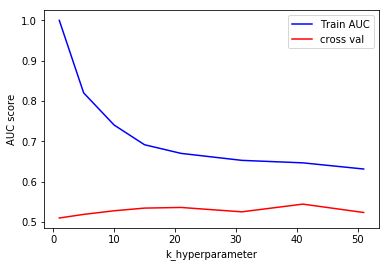

In [56]:
neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()





In [57]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 13)


In [58]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

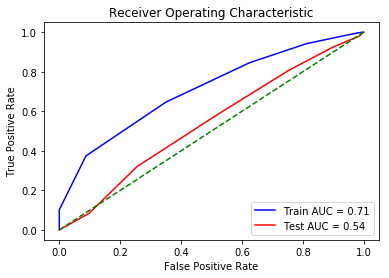

In [59]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[   8  403]
 [   7 2025]]
Test confusion matrix
[[   1  234]
 [   4 1257]]


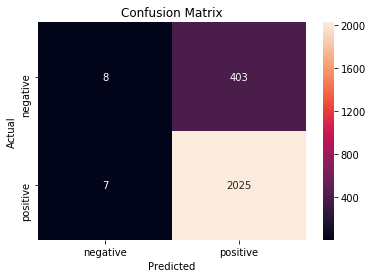

In [61]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

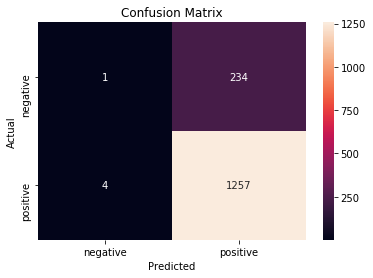

In [62]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [63]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.20      0.00      0.01       235
           1       0.84      1.00      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.52      0.50      0.46      1496
weighted avg       0.74      0.84      0.77      1496



### [5.1.4] Applying KNN brute force on TFIDF W2V, SET 4

In [64]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [65]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
train_tfidf_w2v = tfidf_vect.fit_transform(X_train)
cv_tfidf_w2v = tfidf_vect.transform(X_cv)
test_tfidf_w2v = tfidf_vect.transform(X_test)

In [66]:
import gensim

train_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_train, min_count=5, size=50, workers=4)
train_w2v_words = train_w2v_model[train_w2v_model.wv.vocab]

In [67]:
tfidf_feat = tfidf_vect.get_feature_names()
train_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in train_w2v_words:
            vec = train_w2v_model.wv[word]
            tf_idf = train_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [68]:
cv_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_cv, min_count=5, size=50, workers=4)
cv_w2v_words = cv_w2v_model[cv_w2v_model.wv.vocab]

In [69]:
tfidf_feat = tfidf_vect.get_feature_names()
cv_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_cv:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in cv_w2v_words:
            vec = cv_w2v_model[word]
            tf_idf = cv_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [70]:
test_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_test, min_count=5, size=50, workers=4)
test_w2v_words = test_w2v_model[test_w2v_model.wv.vocab]


In [71]:
tfidf_feat = tfidf_vect.get_feature_names()
test_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_test:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in test_w2v_words:
            vec = test_w2v_model[word]
            tf_idf = test_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [72]:
X_train = train_tfidf_w2v_vectors
X_cv = cv_tfidf_w2v_vectors
X_test = test_tfidf_w2v_vectors

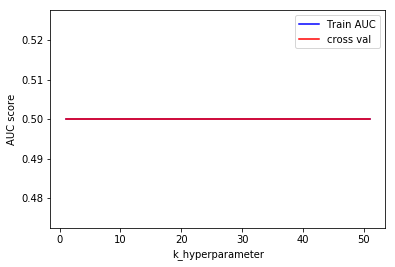

In [73]:
neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()





In [74]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 1)


In [75]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

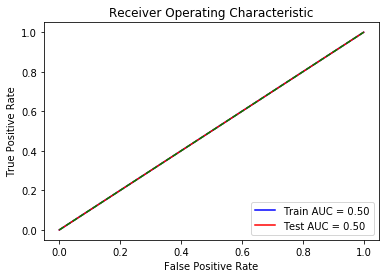

In [76]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[   0  409]
 [   0 2034]]
Test confusion matrix
[[   0  235]
 [   0 1261]]


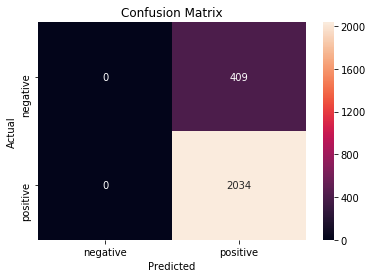

In [78]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

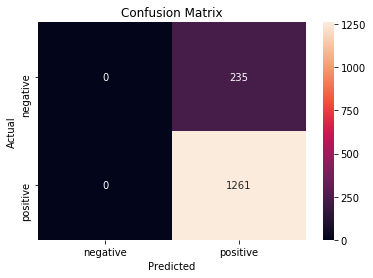

In [79]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [80]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 



C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       235
           1       0.84      1.00      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.42      0.50      0.46      1496
weighted avg       0.71      0.84      0.77      1496



### [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW, SET 5

In [81]:
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# Collecting 100k rows without repetition from time_sorted_data dataframe
my_final = data.take(np.random.permutation(len(final))[:20000])


In [82]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [83]:
count_vect = CountVectorizer(min_df = 10, max_features = 500) 
X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)


C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages

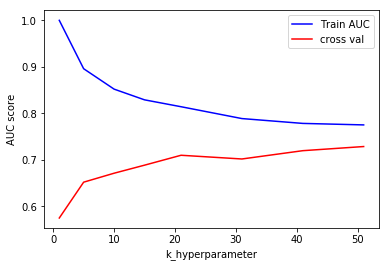

In [84]:

neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()

In [85]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 15)


In [86]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
model.fit(X_train, y_train)

C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

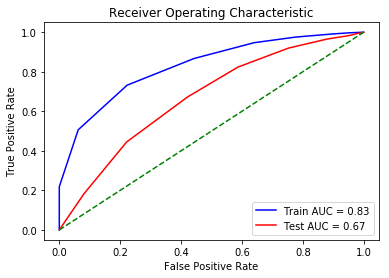

In [87]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [88]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[  16  370]
 [   5 2052]]
Test confusion matrix
[[   5  230]
 [   8 1253]]


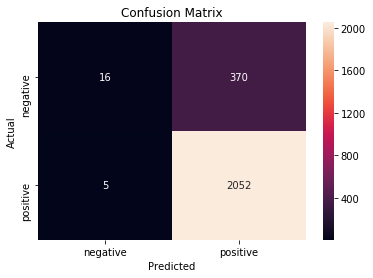

In [89]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

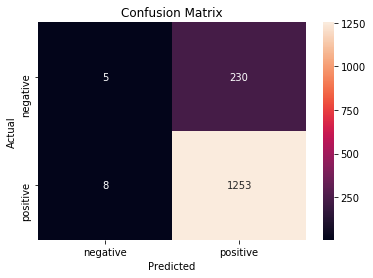

In [90]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [91]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.38      0.02      0.04       235
           1       0.84      0.99      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.61      0.51      0.48      1496
weighted avg       0.77      0.84      0.78      1496



### [5.2.2] Applying KNN kd-tree on TFIDF, SET 6

In [92]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [93]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10,max_features=500)
# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)


#print("the type of count vectorizer ",type(final_tf_idf))
#print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\CCS\Anaconda3\lib\site-packages

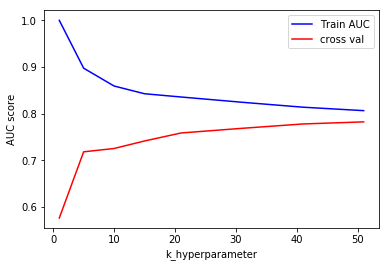

In [94]:

neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()








In [95]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 15)


In [96]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
model.fit(X_train, y_train)

C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

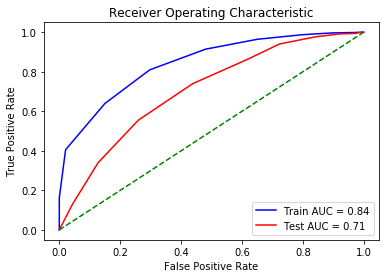

In [97]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [98]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[  40  347]
 [   7 2049]]
Test confusion matrix
[[  19  216]
 [  11 1250]]


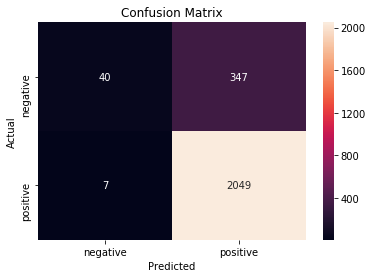

In [99]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

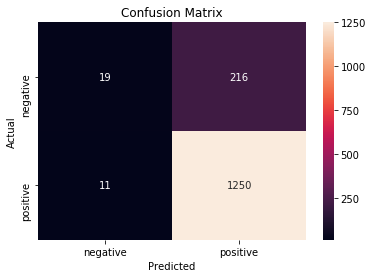

In [100]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [101]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.63      0.08      0.14       235
           1       0.85      0.99      0.92      1261

   micro avg       0.85      0.85      0.85      1496
   macro avg       0.74      0.54      0.53      1496
weighted avg       0.82      0.85      0.80      1496



### [5.1.3] Applying KNN brute force on AVG W2V, SET 3

In [102]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [103]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [104]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

('number of words that occured minimum 5 times ', 3324)
('sample words ', [u'limited', u'ever.', u'better!', u'better,', u'saves', u'Sugar', u'four', u'asian', u'oldest', u'party.', u'worked', u'forget', u'up.', u'increase', u'up,', u'feeding', u'(for', u'seriously', u'up!', u'list', u'teaspoon', u'under', u'sorry', u'worth', u'better.', u'powder.', u'GF', u'powder,', u'container.', u'every', u'jack', u'save.', u'today.', u'pepper.', u"daughter's", u"we'll", u'baking', u'problems.', u'companies', u'time!', u'stars.', u'convenience', u'Go', u'provided', u'commented', u'enjoy', u'chew', u'me!', u'her.', u'tired'])


### Converting Reviews into Numerical Vectors using W2V vectors


### Algorithm: Avg W2V

In [105]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 2443/2443 [00:08<00:00, 274.34it/s]


(2443L, 50L)
[ 0.31909443  0.52489888 -0.49891749  0.21674135 -0.38916871 -0.13470856
 -0.10324264 -0.26544706  0.17713932  0.40592467  0.16759784 -0.2565712
 -0.71180526 -0.25748561  0.18963547  0.49832456  0.10267618 -0.35314197
  0.08788497 -0.74785833 -0.35473135  0.03081618  0.45648054  0.56389999
  0.60122709  0.23476793 -0.14864846  0.10703673 -0.80695253 -0.74385982
 -0.82429511  0.55177011 -0.09337511 -0.27947998 -0.05176773  0.49249192
 -0.08066261  0.42826421  0.26018683 -0.84000994 -0.48160362  0.19325153
 -0.62186335  0.39292678 -0.35891332  0.01710823  0.33008317  0.16775139
  0.30525161  0.21839693]


In [106]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [107]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 1047/1047 [00:03<00:00, 266.48it/s]


(1047L, 50L)
[ 0.2996247   0.50861053 -0.47384893  0.20250442 -0.37060234 -0.14533561
 -0.13548698 -0.27133785  0.17258345  0.39397204  0.17647296 -0.26359707
 -0.69431878 -0.25092742  0.20940816  0.47866701  0.1121147  -0.3385293
  0.05145514 -0.66997544 -0.34173054  0.01644714  0.40369855  0.53408286
  0.5636139   0.20193164 -0.16714032  0.06693038 -0.76952214 -0.68247961
 -0.71990614  0.47780736 -0.1369474  -0.23117888 -0.03762569  0.47370277
 -0.05615747  0.38905834  0.22402124 -0.79620595 -0.45864022  0.20033014
 -0.59368966  0.36363317 -0.35195488  0.04753676  0.29801866  0.18753972
  0.26691055  0.17608533]


In [108]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [109]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 1496/1496 [00:05<00:00, 266.67it/s]


(1496L, 50L)
[ 0.32310362  0.56286131 -0.52302754  0.2175981  -0.39772993 -0.17140841
 -0.15532538 -0.30607212  0.20612773  0.44048878  0.19001787 -0.30988351
 -0.7754515  -0.25620826  0.2233971   0.53539606  0.11991814 -0.33832477
  0.08474063 -0.76817388 -0.38976557  0.01628722  0.44777377  0.58789658
  0.61778966  0.24379239 -0.20146465  0.0657154  -0.84115827 -0.76676375
 -0.8066859   0.50575314 -0.14393226 -0.26261631 -0.04478043  0.51438932
 -0.0613465   0.42061167  0.25508175 -0.85582554 -0.50229644  0.23372682
 -0.68245991  0.41803199 -0.37308687  0.05619551  0.37594861  0.23153715
  0.29144128  0.24568472]


In [110]:
X_train = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

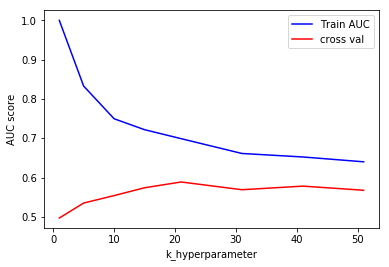

In [111]:

neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()


In [112]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 9)


In [113]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

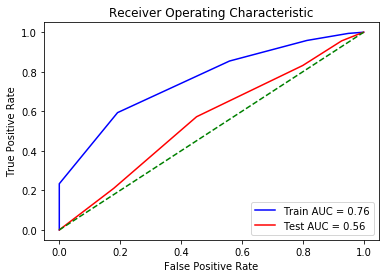

In [114]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [115]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[  20  377]
 [  12 2034]]
Test confusion matrix
[[   3  232]
 [   9 1252]]


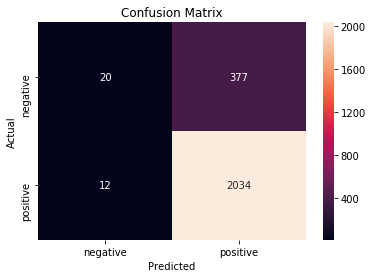

In [116]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

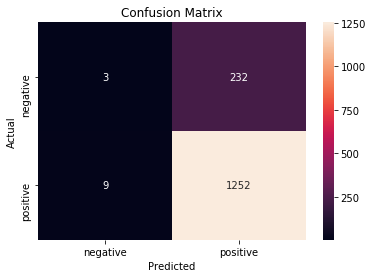

In [117]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [118]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.25      0.01      0.02       235
           1       0.84      0.99      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.55      0.50      0.47      1496
weighted avg       0.75      0.84      0.77      1496



### [5.2.4] Applying KNN kd-tree on TFIDF W2V, SET 4

In [119]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [120]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
train_tfidf_w2v = tfidf_vect.fit_transform(X_train)
cv_tfidf_w2v = tfidf_vect.transform(X_cv)
test_tfidf_w2v = tfidf_vect.transform(X_test)

In [121]:
train_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_train, min_count=5, size=50, workers=4)
train_w2v_words = train_w2v_model[train_w2v_model.wv.vocab]

In [122]:
tfidf_feat = tfidf_vect.get_feature_names()
train_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in train_w2v_words:
            vec = train_w2v_model.wv[word]
            tf_idf = train_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [123]:
cv_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_cv, min_count=5, size=50, workers=4)
cv_w2v_words = cv_w2v_model[cv_w2v_model.wv.vocab]

In [124]:
tfidf_feat = tfidf_vect.get_feature_names()
cv_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_cv:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in cv_w2v_words:
            vec = cv_w2v_model[word]
            tf_idf = cv_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [125]:
test_w2v_model = gensim.models.Word2Vec(
    list_of_sentance_test, min_count=5, size=50, workers=4)
test_w2v_words = test_w2v_model[test_w2v_model.wv.vocab]

In [126]:
tfidf_feat = tfidf_vect.get_feature_names()
test_tfidf_w2v_vectors = []
row = 0
for sent in list_of_sentance_test:
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in test_w2v_words:
            vec = test_w2v_model[word]
            tf_idf = test_tfidf_w2v[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_w2v_vectors.append(sent_vec)
    row += 1

In [127]:
X_train = train_tfidf_w2v_vectors
X_cv = cv_tfidf_w2v_vectors
X_test = test_tfidf_w2v_vectors

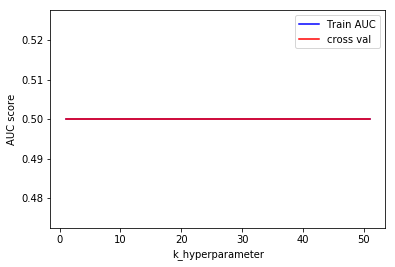

In [128]:

neighbors = [1,5,10,15,21,31,41,51]

train_pred = []
cv_pred    = []
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(neighbors, train_pred, 'b', label = "Train AUC")
plt.plot(neighbors, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('k_hyperparameter')
plt.show()


In [129]:
a = 0
for i in range(len(cv_pred)):
    if(cv_pred[i]> cv_pred[a]):
        a = i
opt_k = a*2 + 1  
print("The optimal k value is: ", opt_k)

('The optimal k value is: ', 1)


In [130]:
best_k = opt_k
model = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

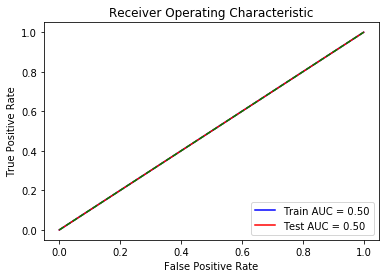

In [131]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [132]:
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test)))

Train confusion matrix
[[   0  404]
 [   0 2039]]
Test confusion matrix
[[   0  235]
 [   0 1261]]


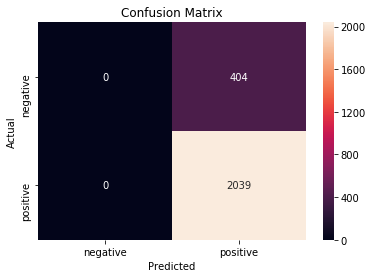

In [133]:
conf_matrix = confusion_matrix(y_train, model.predict(X_train))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

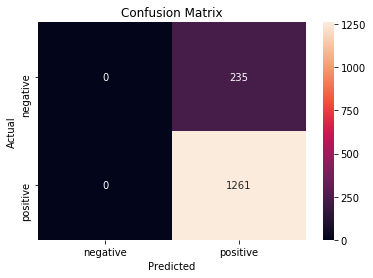

In [134]:
conf_matrix = confusion_matrix(y_test, model.predict(X_test))
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [135]:
print("Classification Report: \n")
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Classification Report: 



C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CCS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       235
           1       0.84      1.00      0.91      1261

   micro avg       0.84      0.84      0.84      1496
   macro avg       0.42      0.50      0.46      1496
weighted avg       0.71      0.84      0.77      1496



### [6] Conclusions

### Brute

In [3]:
from prettytable import PrettyTable
x1 = PrettyTable()
x1.field_names = ["Type","Model", "AUC"]
x1.add_row(["Bag of Words","KNN",0.67])
x1.add_row(["TF-IDF","KNN",0.77])
x1.add_row(["AvgW2V","KNN",0.57])
x1.add_row(["TfidfAvgW2v","KNN",0.50])

print(x1)

+--------------+-------+------+
|     Type     | Model | AUC  |
+--------------+-------+------+
| Bag of Words |  KNN  | 0.67 |
|    TF-IDF    |  KNN  | 0.77 |
|    AvgW2V    |  KNN  | 0.57 |
| TfidfAvgW2v  |  KNN  | 0.5  |
+--------------+-------+------+


### Kd_tree

In [2]:
from prettytable import PrettyTable
x2 = PrettyTable()
x2.field_names = ["Type","Model", "AUC"]
x2.add_row(["Bag of Words","KNN",0.83])
x2.add_row(["TF-IDF","KNN",0.71])
x2.add_row(["AvgW2V","KNN",0.56])
x2.add_row(["TfidfAvgW2v","KNN",0.50])

print(x2)

+--------------+-------+------+
|     Type     | Model | AUC  |
+--------------+-------+------+
| Bag of Words |  KNN  | 0.83 |
|    TF-IDF    |  KNN  | 0.71 |
|    AvgW2V    |  KNN  | 0.56 |
| TfidfAvgW2v  |  KNN  | 0.5  |
+--------------+-------+------+


### Conclusion
Both BOw and Tf-idf gave the best results